
### Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "1"


from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

from sklearn.model_selection import StratifiedKFold

import dill as pickle
import pandas as pd

import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

from tqdm import tnrange, tqdm_notebook

from glob import glob

n_splits=10

PATH='data/happiness/'
TRN_FILE = f'{PATH}/train.csv'
TST_FILE = f'{PATH}/test.csv'

SUBS = f'{PATH}/submissions/'
MODELS = f'{PATH}/models/'

# Test settings
#TRN_FILE = f'{PATH}/train-small.csv'
#TST_FILE = f'{PATH}/test-small.csv'


bs=20; bptt=75
em_sz = 300  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

# Read in data, split training and validation


full_train_df = pd.read_csv(TRN_FILE, index_col=0)
full_train_df.Is_Response.replace(['not happy'], ['not_happy'], inplace=True)

test_df = pd.read_csv(TST_FILE)

strat = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
cv_splits_tmp = strat.split(full_train_df.index,
                            full_train_df['Is_Response'])
cv_splits = []
for split in cv_splits_tmp:
    cv_splits.append(split)
    


### Inspecting data

In [14]:
train_df['device_happy'] = train_df['Device_Used']+'_'+train_df['Is_Response']
train_df['browser_happy'] = train_df['Browser_Used']+'_'+train_df['Is_Response']

In [15]:
def plot(var, df):
    data = [go.Bar(
                x = df[var].unique(),
                y = df[var].value_counts().values,
                marker= dict(colorscale='Jet',
                             color = df[var].value_counts().values
                            ),
                text='Number of comments for this category'
        )]
    layout = go.Layout(
        title='Target variable distribution',
        xaxis = dict(categoryorder='category ascending')
    )

    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, filename='basic-bar')


In [16]:
plot('Is_Response', train_df)

In [17]:
plot('device_happy', train_df)

In [34]:
plot('Device_Used', train_df)

In [35]:
plot('Browser_Used', train_df)

In [18]:
plot('browser_happy', train_df)

### Build language model

In [ ]:
lang_train_df=pd.concat([test_df,full_train_df])

In [7]:
TEXT = torchtext.data.Field(lower=True, tokenize=spacy_tok)

In [8]:
md = LanguageModelData.from_dataframes(PATH, TEXT, 'Description',
      train_df, tiny_df, tiny_df, bs=bs, bptt=bptt, min_freq=7)

In [9]:
pickle.dump(TEXT, open(f'{PATH}/models/h5TEXT.pkl','wb'))

In [10]:
mult=2
DROPOUT=dict(dropouti=0.05*mult, dropout=0.05*mult, wdrop=0.1*mult, dropoute=0.02*mult, dropouth=0.05*mult)

In [11]:
learner = md.get_model(opt_fn, em_sz, nh, nl, **DROPOUT)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [8]:
lrf=learner.lr_find()

A Jupyter Widget

 81%|████████▏ | 966/1187 [02:51<00:39,  5.63it/s, loss=nan] 

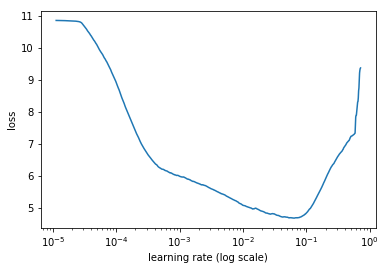

In [9]:
learner.sched.plot()

In [18]:
learner.fit(1e-2, 5, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='h5_adam1')

[ 0.       4.4612   4.67984]                                  
[ 1.       3.8485   3.91509]                                  
[ 2.       3.70472  3.7656 ]                                  
[ 3.       3.75487  3.82334]                                  
[ 4.       3.67886  3.74017]                                  
[ 5.       3.58253  3.64084]                                  
[ 6.       3.56181  3.5991 ]                                  
[ 7.       3.72164  3.77158]                                  
[ 8.       3.68869  3.76386]                                  
[ 9.       3.64241  3.69053]                                  
[ 10.        3.59604   3.65759]                               
[ 11.        3.55332   3.59549]                               
[ 12.        3.50279   3.53896]                               
[ 13.        3.47026   3.50995]                               
[ 14.        3.45431   3.47282]                               
[ 15.        3.65736   3.70558]                        

In [19]:
learner.fit(1e-2, 4, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='h5_adam2')

[ 0.       3.48213  3.49222]                                  
[ 1.       3.54198  3.57655]                                  
[ 2.       3.42899  3.46079]                                  
[ 3.       3.59254  3.64131]                                  
[ 4.       3.51461  3.54973]                                  
[ 5.       3.42882  3.46854]                                  
[ 6.       3.37162  3.38402]                                  
[ 7.       3.59175  3.72203]                                  
[ 8.       3.57833  3.62001]                                  
[ 9.       3.54232  3.57926]                                  
[ 10.        3.48887   3.53993]                               
[ 11.        3.42035   3.49491]                               
[ 12.        3.39485   3.41802]                               
[ 13.        3.34289   3.38387]                               
[ 14.        3.32934   3.35825]                               



In [20]:
learner.fit(1e-2, 2, wds=1e-6, cycle_save_name='h5_adam4')

[ 0.       3.59194  3.64874]                                  
[ 1.       3.59391  3.63885]                                  
[ 2.       3.5902   3.62841]                                  



In [13]:
learner.fit(1e-2, 6, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='h5_adam5')

Widget Javascript not detected.  It may not be installed or enabled properly.


[ 0.       3.44062  3.47874]                                  
[ 1.       3.51631  3.55192]                                  
[ 2.       3.37249  3.39874]                                  
[ 3.       3.5635   3.63265]                                  
[ 4.       3.49326  3.52714]                                  
[ 5.       3.4001   3.46319]                                  
[ 6.       3.34938  3.37554]                                  
[ 7.       3.58485  3.6219 ]                                  
[ 8.       3.56327  3.5995 ]                                  
[ 9.       3.52391  3.56978]                                  
[ 10.        3.47817   3.5462 ]                               
[ 11.        3.42828   3.49216]                               
[ 12.        3.3739    3.40695]                               
[ 13.        3.31672   3.35445]                               
[ 14.        3.31605   3.34446]                               
[ 15.        3.57481   3.63894]                        

In [26]:
learner.fit(1e-2, 6, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='h5_adam6')

Widget Javascript not detected.  It may not be installed or enabled properly.


[ 0.       3.39287  3.42433]                                  
[ 1.       3.46124  3.50182]                                  
[ 2.       3.35253  3.36784]                                  
[ 3.       3.54116  3.59807]                                  
[ 4.       3.46228  3.50665]                                  
[ 5.       3.36589  3.58602]                                  
[ 6.       3.29823  3.36935]                                  
[ 7.       3.54665  3.62275]                                  
[ 8.       3.51633  3.58916]                                  
[ 9.       3.49357  3.55419]                                  
[ 10.        3.41506   3.5307 ]                               
[ 11.        3.37939   3.46906]                               
[ 12.        3.34791   3.41782]                               
[ 13.        3.31168   3.35296]                               
[ 14.        3.29382   3.34562]                               
[ 15.        3.53213   3.60446]                        

In [27]:
learner.save_encoder('h5_adam6_enc')
learner.save('h5_adam6')

In [12]:
learner.load_cycle('h5_adam2', 3)
learner.save_encoder('h5_adam2_cyc3_enc')

### Checking the language model

In [22]:
m=learner.model
ss=". the staff was not very friendly, and I "
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

'. the staff was not very friendly , and I'

In [23]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [24]:
print(ss,"\n")
for i in range(70):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

. the staff was not very friendly, and I  

. the room was clean and the bed was comfortable . the room was clean and the bed was comfortable . the room was clean and the bed was comfortable . the location is great , right in the middle of everything . the staff was very friendly and helpful . the location is great , right in the middle of everything . the staff was very friendly and helpful ...


### find learning rate

In [34]:
lrf=learner.lr_find()


Widget Javascript not detected.  It may not be installed or enabled properly.


 81%|████████▏ | 1501/1843 [01:52<00:25, 13.33it/s, loss=12.3]

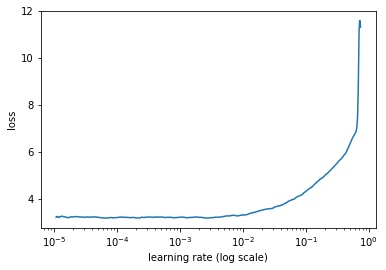

 81%|████████▏ | 1501/1843 [02:10<00:29, 11.54it/s, loss=12.3]

In [35]:
learner.sched.plot()

### helper functions

In [2]:
model_name_base = 'h_cv_class4D_543LR_'+str(n_splits)+'S'
i=0

# function for renaming model and predictions files during CV looping
def get_model_name(base, i):
    name = base+str(i+1)
    #print(name)
    return name, i+1

def make_predictions(model, the_df, filename, TEXT, LABEL, probabilities=False):
    m = model.model
    m[0].bs = 1
    preds = []
    for i in tnrange(len(the_df)):
        ss = the_df["Description"][i] #Actual text review
        s = [spacy_tok(ss)]
        t = TEXT.numericalize(s)

        m.eval()
        m.reset()
        res,*_ = m(t)
        prediction = LABEL.vocab.itos[to_np(torch.topk(res[-1], 1)[1])[0]]
        if probabilities:
            prediction = to_np(F.softmax(np.exp(res[-1].data))[0])[0]
        preds.append(prediction)
    final_preds = pd.DataFrame({'User_ID': the_df.reset_index()['User_ID'],
                                'Is_Response': preds})
    final_preds[['User_ID', 'Is_Response']].to_csv(filename, index=False)
    print('Finished: '+filename)

# Class needed for sending data to torchtext
class PredictHappinessDataset(torchtext.data.Dataset):
    def __init__(self, path, text_field, label_field, device_field, browser_field, dfs, **kwargs):
        fields = [("text", text_field), ("label", label_field), ("device", device_field), ("browser", browser_field) ]
        examples = []
        for i in range(dfs[path].values[:,1].shape[0]):
            text = dfs[path].Description[i]
            label = None
            device = dfs[path].Device_Used[i]
            browser = dfs[path].Browser_Used[i]
            if 'Is_Response' in dfs[path]:
                label = dfs[path].Is_Response[i]
            examples.append(data.Example.fromlist([text, label, device, browser], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, path,
               train, val, test, dfs, device_field, browser_field, **kwargs):
        return super().splits(path,
            text_field=text_field, label_field=label_field, 
            train=train, validation=val, test=test, dfs=dfs, device_field = device_field, browser_field = browser_field, **kwargs)

## cross validation, but in this version only setting up model architecture and loading previously trained weights, then making predictions
def run_cv(string, my_df):
    i=0
    for (train_ids, val_ids) in cv_splits:

        tmp_model_name, i = get_model_name(model_name_base, i)
        modelFile = MODELS+tmp_model_name+'.h5'
        if os.path.isfile(modelFile):
            csvFile = SUBS+'/'+tmp_model_name+'-'+string+'.csv'
            if not os.path.isfile(csvFile):
                pass
            else:
                #print("CSV already exists: "+csvFile)
                continue
        else:
            #print("Model not yet ready: "+modelFile)
            continue

        train_df=full_train_df.iloc[train_ids]
        val_df=full_train_df.iloc[val_ids]

        df = {'train': train_df, 'val': val_df, 'test': None}

        TEXT = pickle.load(open(f'{PATH}models/h5TEXT.pkl','rb'))
        LABEL = data.Field(sequential=False, use_vocab=False, unk_token=None)
        DEVICE = data.Field(sequential=False)
        BROWSER = data.Field(sequential=False)
        splits = PredictHappinessDataset.splits(TEXT, LABEL, '',
                                     train='train',
                                     val='val', test=None, dfs=df, device_field=DEVICE, browser_field=BROWSER)
        md2 = TextData.from_splits(PATH, splits, bs)
        BROWSER.build_vocab(splits[0])
        DEVICE.build_vocab(splits[0])

        # Initialize learner

        dropouti, dropout, wdrop, dropoute, dropouth = np.array([0.05,0.05,0.1,0.02,0.05])*4
        m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
                   dropouti=dropouti, dropout=dropout, wdrop=wdrop,
                               dropoute=dropoute, dropouth=dropouth)
        m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
        m3.load_encoder(f'h5_adam6_enc')

        m3.load(tmp_model_name)
        make_predictions(m3, my_df, csvFile, TEXT, LABEL, probabilities=True)


### Make predictions using previously trained models from CV

In [9]:
import time
starttime=time.time()

while True:
    print('.',end='')
    run_cv('train', full_train_df)
    #run_cv('test', test_df)
    time.sleep(60.0 - ((time.time() - starttime) % 60.0))



.


Finished: data/happiness//submissions//h_cv_class4D_543LR_10S1-train.csv



Finished: data/happiness//submissions//h_cv_class4D_543LR_10S2-train.csv



Finished: data/happiness//submissions//h_cv_class4D_543LR_10S3-train.csv



Finished: data/happiness//submissions//h_cv_class4D_543LR_10S4-train.csv



Finished: data/happiness//submissions//h_cv_class4D_543LR_10S5-train.csv



Finished: data/happiness//submissions//h_cv_class4D_543LR_10S6-train.csv



Finished: data/happiness//submissions//h_cv_class4D_543LR_10S7-train.csv



Finished: data/happiness//submissions//h_cv_class4D_543LR_10S8-train.csv



Finished: data/happiness//submissions//h_cv_class4D_543LR_10S9-train.csv



Finished: data/happiness//submissions//h_cv_class4D_543LR_10S10-train.csv
....

KeyboardInterrupt: 

### average predictions

In [7]:
def get_label(x):
    return 'not_happy' if x >= .5 else 'happy'

def make_avg_preds(string,df):
    subs = glob(SUBS+'/'+model_name_base+'*'+string+'*.csv')
    cv_preds = []
    for s in subs:
        d = pd.read_csv(s)
        cv_preds.append(d['Is_Response'].tolist())
    if len(cv_preds) == 0:
        return
    avg_preds = np.stack(cv_preds).mean(axis=0)

    labels = list(map(get_label, avg_preds))

    CV_AVG_PREDS = f'{SUBS}/cv_ensemble_'+str(n_splits)+'S_avg_preds-labels-'+string+'.csv'
    CV_AVG_PREDS_PROBA = f'{SUBS}/cv_ensemble_'+str(n_splits)+'S_avg_preds-proba-'+string+'.csv'

    avg_preds_df = pd.DataFrame({'User_ID': df.reset_index()['User_ID'],
                                 'Is_Response': labels})

    avg_preds_proba_df = pd.DataFrame({'User_ID': df.reset_index()['User_ID'],
                                 'Is_Response': avg_preds})
    avg_preds_proba_df[['User_ID', 'Is_Response']].to_csv(CV_AVG_PREDS_PROBA, index=False)
    avg_preds_df[['User_ID', 'Is_Response']].to_csv(CV_AVG_PREDS, index=False)

make_avg_preds('train', full_train_df)
make_avg_preds('test', test_df)

In [12]:
print(model_name_base)
print(np.vstack(subs))

h_cv_class4D_543LR_10S
[['data/happiness//submissions/h_cv_class4D_543LR_10S4-test.csv']
 ['data/happiness//submissions/h_cv_class4D_543LR_10S7-test.csv']
 ['data/happiness//submissions/h_cv_class4D_543LR_10S5-test.csv']
 ['data/happiness//submissions/h_cv_class4D_543LR_10S10-test.csv']
 ['data/happiness//submissions/h_cv_class4D_543LR_10S8-test.csv']
 ['data/happiness//submissions/h_cv_class4D_543LR_10S2-test.csv']
 ['data/happiness//submissions/h_cv_class4D_543LR_10S3-test.csv']
 ['data/happiness//submissions/h_cv_class4D_543LR_10S6-test.csv']
 ['data/happiness//submissions/h_cv_class4D_543LR_10S9-test.csv']
 ['data/happiness//submissions/h_cv_class4D_543LR_10S1-test.csv']]


### playground

In [ ]:
m = m3.model
m[0].bs = 1
preds = []

ss = full_train_df["Description"][4] #Actual text review
s = [spacy_tok(ss)]
t = TEXT.numericalize(s)

m.eval()
m.reset()
res,*_ = m(t)

In [4]:
prediction = LABEL.vocab.itos[to_np(torch.topk(res[-1], 1)[0])[0]]

TypeError: list indices must be integers or slices, not numpy.float32

In [5]:
res[-1]

Variable containing:
 0.2201
-0.1449
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [6]:
torch.topk(res[-1], 1)

(Variable containing:
  0.2201
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0
 [torch.cuda.LongTensor of size 1 (GPU 0)])

In [10]:
torch.topk(res[-1], 1)[1]

Variable containing:
 0
[torch.cuda.LongTensor of size 1 (GPU 0)]

In [13]:
to_np(torch.topk(res[-1], 1)[1])

array([0])

In [14]:
to_np(torch.topk(res[-1], 1)[1])[0]

0